# Instance Segmentation on the OCID Dataset

This notebook provides a demonstration on training and inferencing a category-agnostic instance segmentation model on the __[OCID grasp](https://github.com/stefan-ainetter/grasp_det_seg_cnn)__ dataset. Other suitable datasets can be used by changing the root dataset directory path `root_dir` and the dataset annotation file path `annotation_path` in the dataset object `InstanceSegmentationDataset`. If training a model or visualizing a dataset, you will need to generate a JSON annotation file for the dataset you want to use (refer to the __[README](../README.md/#generating-annotation-files)__ for additional details). An annotation file is not needed for inferencing the model with random images.



In [1]:
# import standard libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm
torch.manual_seed(1)

# add root code directory to python path
current_dir = os.path.dirname(os.path.abspath(''))
print(f"[INFO] Adding '{current_dir}' to python path.")
sys.path.append(current_dir)

# import libraries from os_tog
import os_tog.model as m
import os_tog.dataset as d
from os_tog.config import InstanceSegmentationConfig as cfg
from os_tog.utils import visualize, print_losses

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

[INFO] Adding 'd:\PhD Projects\OS_TOG (Github)' to python path.


## Loading a Dataset

The code below is used to generate dataset objects and data loaders, as well as preview some segmentation annotations from the dataset. Category agnostic denotes that all objects have the same label ("object" or "1") regardless of their true object category.

> Note that the testing and validation data splits are the same for the OCID grasp dataset.

In [2]:
# define transformations
def get_transform(train=True):
    transforms = []
    if train:
        transforms.append(d.RandomHorizontalFlip(p=0.5))
    transforms.append(d.ToTensor())
    return d.Compose(transforms)

# create dataset objects
train_dataset = d.InstanceSegmentationDataset(
    root_dir=cfg.OCID_PATH,
    annotation_file=os.path.join(cfg.OCID_ANNOT_PATH, "OCID_training_annotations.json"), 
    transforms=get_transform()
)
test_dataset = d.InstanceSegmentationDataset(
    root_dir=cfg.OCID_PATH, 
    annotation_file=os.path.join(cfg.OCID_ANNOT_PATH, "OCID_validation_annotations.json"), 
    transforms=get_transform(train=False)
)

# create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=cfg.TRAIN_BATCH_SIZE, shuffle=True, num_workers=cfg.NUM_WORKERS, collate_fn=d.collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg.TEST_BATCH_SIZE, shuffle=False, num_workers=cfg.NUM_WORKERS, collate_fn=d.collate_fn
)

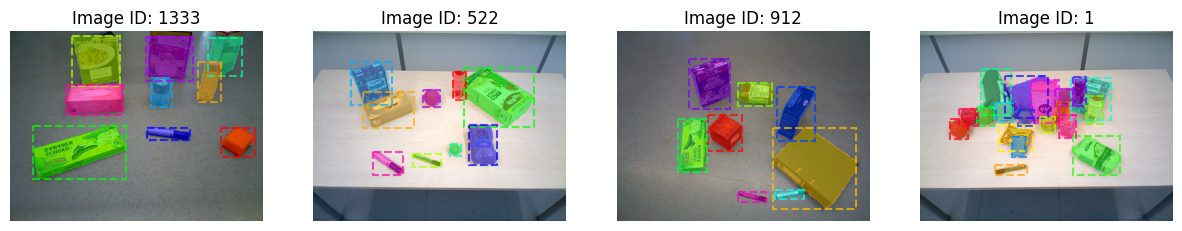

In [3]:
_, ax = plt.subplots(cfg.TRAIN_BATCH_SIZE//4, 4, figsize=(15, 6))

batch = next(iter(train_loader))
for batch_idx in range(len(batch[0])):
    img, target = batch[0][batch_idx], batch[1][batch_idx]
    img = np.array(torchvision.transforms.ToPILImage()(img)) # convert image from tensor to image for plotting
    visualize(img, boxes=target['boxes'], masks=target['masks'], class_ids=['labels'], ax=ax[batch_idx], title=f"Image ID: {target['image_id'].item()}")

## Building a Model

The code below builds a Mask R-CNN category-agnostic instance segmentation model with a Resnet-50 FPN backbone and displays its structure and parameters.

In [4]:
model = m.build_instance_segmentation_model()

In [5]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO] Total model params:", pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO] Total trainable params:", pytorch_total_params)

print(f"[INFO] Printing model...")
print(model)

[INFO] Total model params: 43922395
[INFO] Total trainable params: 43699995
[INFO] Printing model...
MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), 

## Training a Model

The code below can be used to train the model for N epochs. It prints losses and saves the model at each epoch.

In [6]:
# set model to GPU for training
model.to(DEVICE)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=cfg.LEARNING_RATE)

train_hist = {}  # to store training and validation losses
for epoch in range(1, cfg.EPOCHS+1):
    # train model for one epoch
    train_hist = m.train_instance_segmentation_model(model, train_loader, optimizer, epoch, DEVICE, train_hist)
    print_losses(train_hist, epoch)
    m.save_model(model, cfg.MODEL_DIR, f"{cfg.MODEL_NAME}_{epoch}.pt")

Training Epoch 1: 100%|██████████| 353/353 [02:37<00:00,  2.24it/s, loss=0.342]


Epoch 1 - loss: 0.4653 - cls_loss: 0.0915 - bbox_loss: 0.1838 - mask_loss: 0.1741 - rpn_cls_loss: 0.0072 - rpn_bbox_loss: 0.0087
[INFO] Saving checkpoint '../models/instance_segmentation\maskrcnn_OCID_t1_1.pt'


## Inferencing a Model

The code below is used to load a checkpoint and inference the model on either samples from the test dataset or on a random image.

In [2]:
model = m.build_instance_segmentation_model()
model = m.load_model(model, '../models/instance_segmentation/maskrcnn_OCID_t1_1.pt')
model.eval()
model.to(DEVICE);

[INFO] Loading checkpoint '../models/instance_segmentation/maskrcnn_OCID_t1_1.pt'
[INFO] Loaded checkpoint '../models/instance_segmentation/maskrcnn_OCID_t1_1.pt'


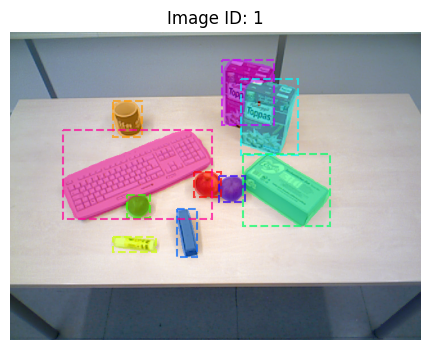

In [4]:
batch = next(iter(test_loader)) # get batch
img, target = batch[0][0], batch[1][0]
img = img.to(DEVICE)
masks, pred_boxes, pred_class = m.inference_instance_segmentation_model(model, img, confidence=cfg.CONFIDENCE)
img = np.array(torchvision.transforms.ToPILImage()(img)) # convert image from tensor to image for plotting
visualize(img, boxes=pred_boxes, masks=masks, class_ids=pred_class, title=f"Image ID: {target['image_id'].item()}")

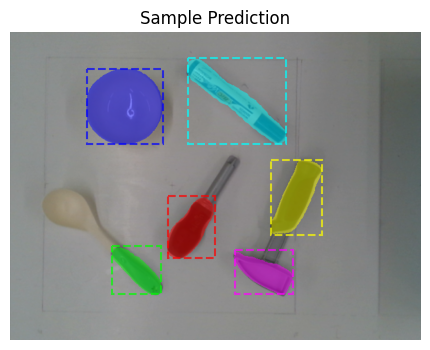

In [3]:
img_path = "../samples/example_scene.png"
img = Image.open(img_path)
transform = T.Compose([T.ToTensor()])
img = T.ToTensor()(img)
img = img.to(DEVICE)
masks, pred_boxes, pred_class = m.inference_instance_segmentation_model(model, img, confidence=cfg.CONFIDENCE)
img = np.array(torchvision.transforms.ToPILImage()(img)) # convert image from tensor to image for plotting
visualize(img, boxes=pred_boxes, masks=masks, class_ids=pred_class, title=f"Sample Prediction")